In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_15traps.csv
/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_notraps.csv
/kaggle/input/stoats-no-traps-radius-10/all.csv
/kaggle/input/stoats-radius-20/all.csv
/kaggle/input/stoats-traps-population-equal-traps/stoatdeath_singleexample_density025_15stoats_r10_15traps.csv
/kaggle/input/stoats-no-traps-r-20/all.csv
/kaggle/input/stoats-steps-to-food-death/stepstofooddeath.csv
/kaggle/input/stoats-populations-no-traps-stoatdeath/stoatdeath_singleexample_density025_15stoats_r10_notraps.csv
/kaggle/input/stoats-radius-10/all.csv


# 1. Introduction

Invasive stoat populations in New Zealand have been a key factor for the decline of endemic species on the islands since their introduction in the late 19th century. Endemic bird populations have observed the steepest decline with many ground-nesting birds oblivious to this newly introduced predator. The aims of our project are to (1) model the spread and growth of invasive stoat populations on an isolated island in New Zealand, (2) model and determine the optimal number of stoat traps, and (3) expand our model to account for key endemic bird and other prey populations. The combined findings of aims 1-3 will allow us to predict the future status of New Zealand stoat populations and their effects on certain endemic prey populations. 

# 2. Background

Invasive stoat populations in New Zealand have been a key factor for the decline of endemic species on the islands since their introduction in the late 19th century. They were originally introduced to control rabbit populations that were destroying sheep pasture. Endemic bird populations have observed the steepest decline with many ground-nesting birds oblivious to this newly introduced predator. Stoats can live in any habitat where they can find prey, swim across kilometer long gaps to reach islands, and are avid climbers. This versatility has allowed the species to proliferate many of the islands in New Zealand, with stoats being detected on at least 90 islands. The primary aim of this project is to model the spread and growth of invasive stoat populations on an isolated island in New Zealand. Additional aims include the modeling and determination of optimal numbers of stoat traps as well as an expansion of the model to include key prey populations. Ideally, such a model will allow us to predict population sizes and distributions for use in conservation management.
.


We anticipate the use of two distinct modeling types for this project. We will first employ dynamical system population modeling, using differential equations to define stoat population sizes. Inputs into this model include but are not limited to food availability, length of life, and climate conditions. We expect the output to be an exponential growth in stoats, due to a lack of predation or trapping. We then intend to model stoat population spread by agent-based modeling, in which stoat populations can be confined to a defined area. Model inputs will build off of the dynamical system, additionally considering island size and reproductive behavior. This model will factor in traps, so we expect slowed stoat growth. Considering our final aim, we expect any rise in stoat populations to be followed by a decline in prey species. Our final models should allow us to identify key parameters for stoat population control, with use in real-world conservation biology.

# 3. Model Descriptions

Establishing the parameters that determine stoat distributions across isolated islands allows researchers to evaluate the causes and effects of stoat invasions. Here we analyze stoat population size via dynamical systems modeling and describe invasion behaviors with agent-based modeling.

**3.1 Dynamical Systems**

To model the growth of stoat populations and subsequent prey populations, we are using dynamical system modeling. We initially used the Lotka–Volterra model using parameters such as predator and prey density, growth rate, and death rate, where x is the density of prey, a is the prey growth rate, and b is the prey death rate. In the stoat differential equation, y is stoat density, d is growth rate, and o is death rate. 

General predator-prey model

$$
\begin{align}
\frac{\partial x}{\partial t} &= ax - bxy \\
\frac{\partial y}{\partial t} &= -oy + dxy
\end{align}
$$


This model works only when predator and prey populations are initially similar. In reality, the prey population is exceptionally higher than the stoat populations. So, we will instead introduce a new model taking into account the environment's carrying capacity and rate of prey consumption. 

Modeling Stoat Growth
$$
\begin{align}
\frac{dy}{dt} = d * y * (1 - \frac{y}{K}) - h * y - (o / x * E) * y
\end{align}
$$

Modeling Prey Growth/Depletion
$$
\begin{align}
\frac{dx}{dt} = a * x * (1 - \frac{x}{Kf}) - c * x * y - b * x
\end{align}
$$

We used a logistic model including parameters of carrying capacity, rate of predation, and hunting efficiency, where Kf is prey carrying capacity, K is stoat carrying capacity, c is rate of predation, and h is hunting efficiency. This model gave us a better look at how certain constraints could have an effect on both populations.

**3.2 Agent Based Modeling**

In order to account for island size, we used agent-based modeling to describe invasive stoat population growth. Modifiable parameters include the number of stoats, the radius of the island, the density of food available to the stoats, and the number of traps on the island.  

The primary driver of stoat behavior is hunger. Stoats will wander around their island until they find a neighboring piece of food, which will then become their target. 

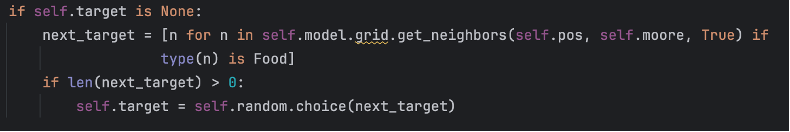

Stoats then track the target until they are able to eat it or they get too hungry and need to go home. After eating, stoats will return to their home and, if they had any leftover food, will stash it away for later.

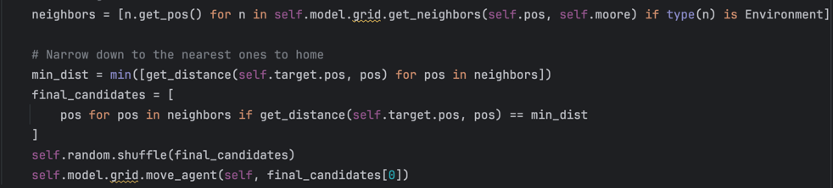

This model is limited by difficulties in modeling the passage of time and the behaviors of individual prey populations. To balance the passage of time and the number of steps required to complete a model, one step is equivalent to one hour. There are three hours per day and 36 days per year. Every 9 days, the season changes, allowing for reproduction during the Spring. Stoats die after 1000 time steps, if they are not otherwise killed by hunger or a trap.

Prey populations wonder the island randomly, as they are broadly generalized populations that likely display varying patterns of behavior. Additionally, many endemic bird populations which fall prey to stoats have no natural predators and might struggle to avoid such adept hunters. 

# 4. Evaluation

**3.1 Dynamical Systems**

In [2]:
from plotnine import *
from scipy.integrate import odeint
import math
import pandas as pd
import numpy as np

Using dynamical systems modeling, our first aim was to understand the relationship between stoat populations and predator populations via predator-prey modeling. 

We can first gain a general understanding of the predator-prey relationship using the Lotka-Volterra model. 

**Note:** this model makes several assumptions about the environment including that (1) prey populations have an unlimited supply of food, (2) predators have limitless appetite, and (3) populations are not limited by space.


General predator-prey model

$$
\begin{align}
\frac{\partial x}{\partial t} &= ax - bxy \\
\frac{\partial y}{\partial t} &= -oy + dxy
\end{align}
$$


In [3]:
# Parameters

x = 10.0 # prey density
y = 10.0 # stoat density
a = 1.1 # prey growth
b = 0.4 # prey death rate
o = 0.4 # stoat death rate
d = 0.1 # stoat growth

In [4]:
# Lotka–Volterra model
sim_length = 48

def euler(func, initial, deltas):
    vals = [initial]
    for i in range(1, len(deltas)):
        cur = np.array(vals[-1][:])
        dt = deltas[i] - deltas[i - 1]
        cur += func(cur, dt)
        vals.append(cur)
    return np.array(vals)

def predprey(u, dt):
    x, y = u
    dx = (a * x - b * x * y) * dt
    dy = (-o * y  + d * x * y) * dt
    return [dx, dy]

time = np.linspace(0, sim_length, sim_length * 3000)
pop = euler(predprey, [x, y], time)

In [5]:
df = pd.DataFrame(pop, columns=["prey", "stoat"])
df["time"] = time

In [6]:
dfmelt=pd.melt(df, id_vars=['time'], value_vars=["prey", "stoat"], 
               var_name='species', value_name='population')

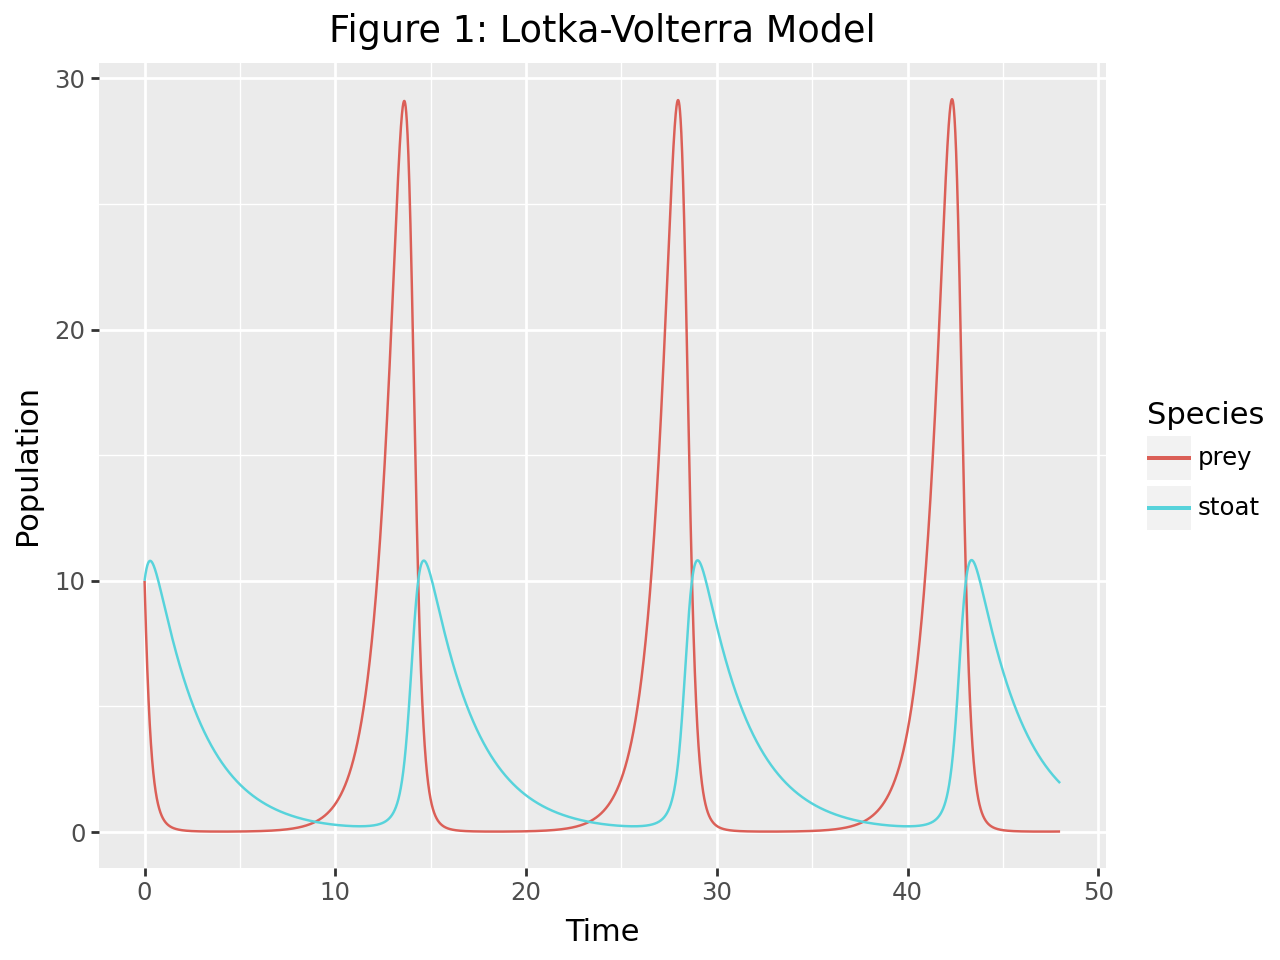

In [7]:
(
    ggplot(dfmelt, aes("time", "population", color="species"))
    + geom_line()
    + ggtitle("Figure 1: Lotka-Volterra Model")
    + labs(color="Species")
    + xlab("Time")
    + ylab("Population")
)

From the model above, we can see the dynamics of stoat and prey populations. An equilibrium is formed between the two populations, where an increase in prey leads to an increase in stoats, which then causes the prey population to decline, leading to a subsequent decrease in stoats. The patterns shown in the model have been observed in certain real-life examples and can provide insight on how stoat and prey populations may interact.

However, in most natural populations, many of the assumptions of the Lotka-Volterra model do not hold true. The model lacks several considerations such as that of carrying capacity and predator rate of consumption. These factors will be important in understanding how stoats may interact with prey species on the isolated islands of New Zealand. Therefore, we will introduce a new model taking these factors into account.

Modeling Stoat Growth
$$
\begin{align}
\frac{dy}{dt} = d * y * (1 - \frac{y}{K}) - h * y - (o / x * E) * y
\end{align}
$$

Modeling Prey Growth/Depletion
$$
\begin{align}
\frac{dx}{dt} = a * x * (1 - \frac{x}{Kf}) - c * x * y - b * x
\end{align}
$$

In [8]:
# Parameters
x = 90.0  # prey density
y = 10.0   # stoat density
a = 0.3   # prey growth rate
b = 0.01   # prey death rate
o = 0.04  # stoat death rate
d = 0.2   # stoat growth rate
K = 300   # stoat carrying capacity
Kf = 2500 # prey carrying capacity
h = 0.05 # hunting efficiency
c = 0.005 # rate of predation
epsilon = 1e-6  # small constant to avoid division by zero
x_crit = 1.0    # prey density threshold for collapse

sim_length = 200

def predprey(u, dt):
    x, y = u

    if x > x_crit:
        dx = a * x * (1 - (x / Kf)) - c * y * x - b * x
    else:
        dx = -b * x
    
    if x > x_crit:
        dy = d * y * (1 - (y / K)) - h * y - (o / (x + epsilon)) * y
    else:
        dy = -o * y
    
    return [dx, dy]


time = np.linspace(0, sim_length, sim_length * 3000)

pop = odeint(predprey, [x, y], time)

In [9]:
df = pd.DataFrame(pop, columns=["prey", "stoat"])
df["time"] = time

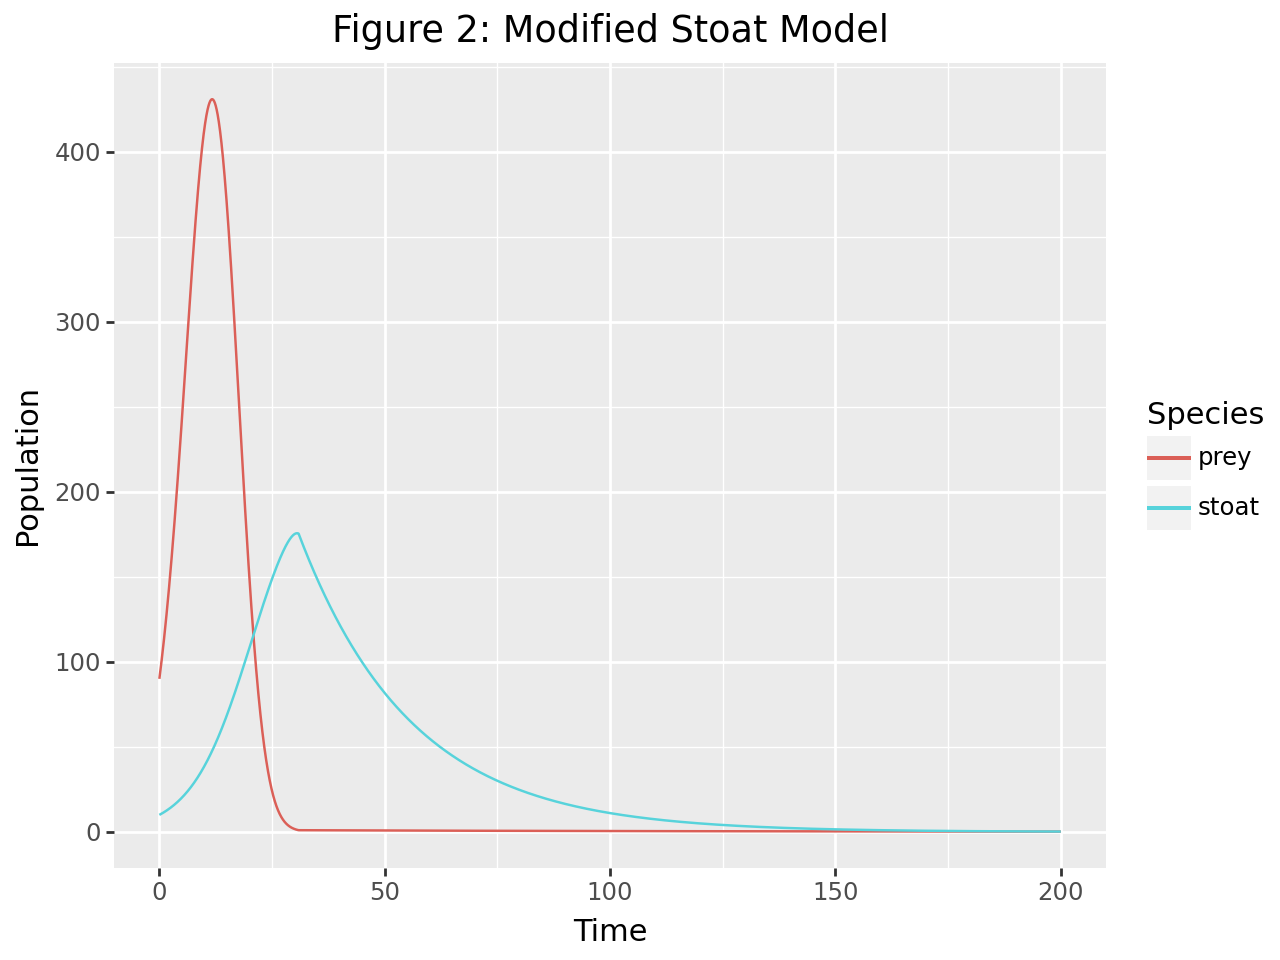

In [10]:
dfmelt=pd.melt(df, id_vars=['time'], value_vars=["prey", "stoat"], 
               var_name='species', value_name='population')


(
    ggplot(dfmelt, aes("time", "population", color="species"))
    + geom_line()
    + ggtitle("Figure 2: Modified Stoat Model")
    + labs(color="Species")
    + xlab("Time")
    + ylab("Population")
)

The model above shows a more realistic interaction between stoat and prey populations taking into account realistic limitations of space and hunting efficiency. While stoat populations are low, prey populations increase exponentially. As stoat populations increase, the prey population's rate of growth decreases, and at a certain stoat population size, prey populations begin to decrease. 

Note that by the end of the simulation prey populations plateau at 0 and stoat populations are decreasing towards 0. Prey populations reach 0 and are unable to rebound, unlike the Lotka-Volterra model. Stoat populations are decreasing due to a lack in prey availability.

**3.2 Agent Based Modeling**

*Due to its size, the agent-based model itself is available in a supplemental notebook. Here, we will evaluate and discuss the results of the model.*

**AIM 1:**

Our first aim was to evaluate stoat population survival on variable isolated islands. We first investigated the population dynamics within our ABM. 

In [11]:
df = pd.read_csv("/kaggle/input/stoats-populations-no-traps-stoatdeath/stoatdeath_singleexample_density025_15stoats_r10_notraps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1

In [12]:
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]

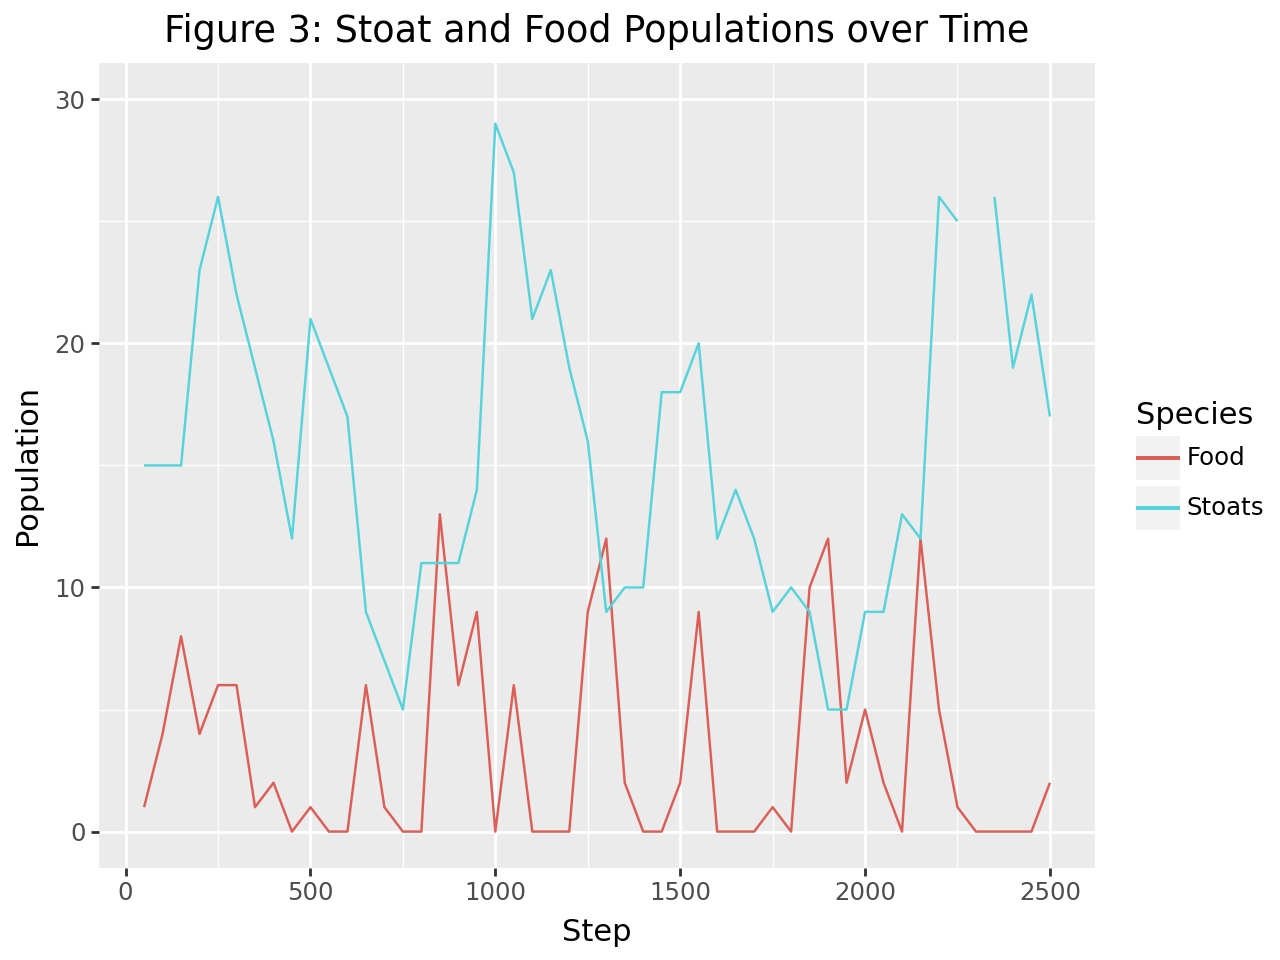

In [13]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ylim(0, 30)
    + ggtitle("Figure 3: Stoat and Food Populations over Time")
    + xlab("Step")
    + ylab("Population")
    + labs(color="Species")
)

As seen above, prey populations quickly dip, thus for the sake of the simulation, food is "regenerated" periodically to support the stoats. This imitates plant and prey growth in the real world. This provides somewhat cyclical population growth and decline over time.

To evaluate this further, we ran batch simulations of the ABM which terminated upon the death of the final stoat. These simulations were run in triplicate on variable food densities (0.1, 0.25, 0.5), island sizes (radius 10, 20), and stoat numbers (5, 15, 25).

In [14]:
df = pd.read_csv("/kaggle/input/stoats-no-traps-radius-10/all.csv")
df2 = pd.read_csv("/kaggle/input/stoats-no-traps-r-20/all.csv")

df = pd.concat([df, df2], axis=0, ignore_index=True)

In [15]:
df_average = df.groupby(['stoats', 'food_density', 'radius'], as_index=False, sort=False)['Step'].mean()

df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["radius"] = df_average["radius"].astype("category")


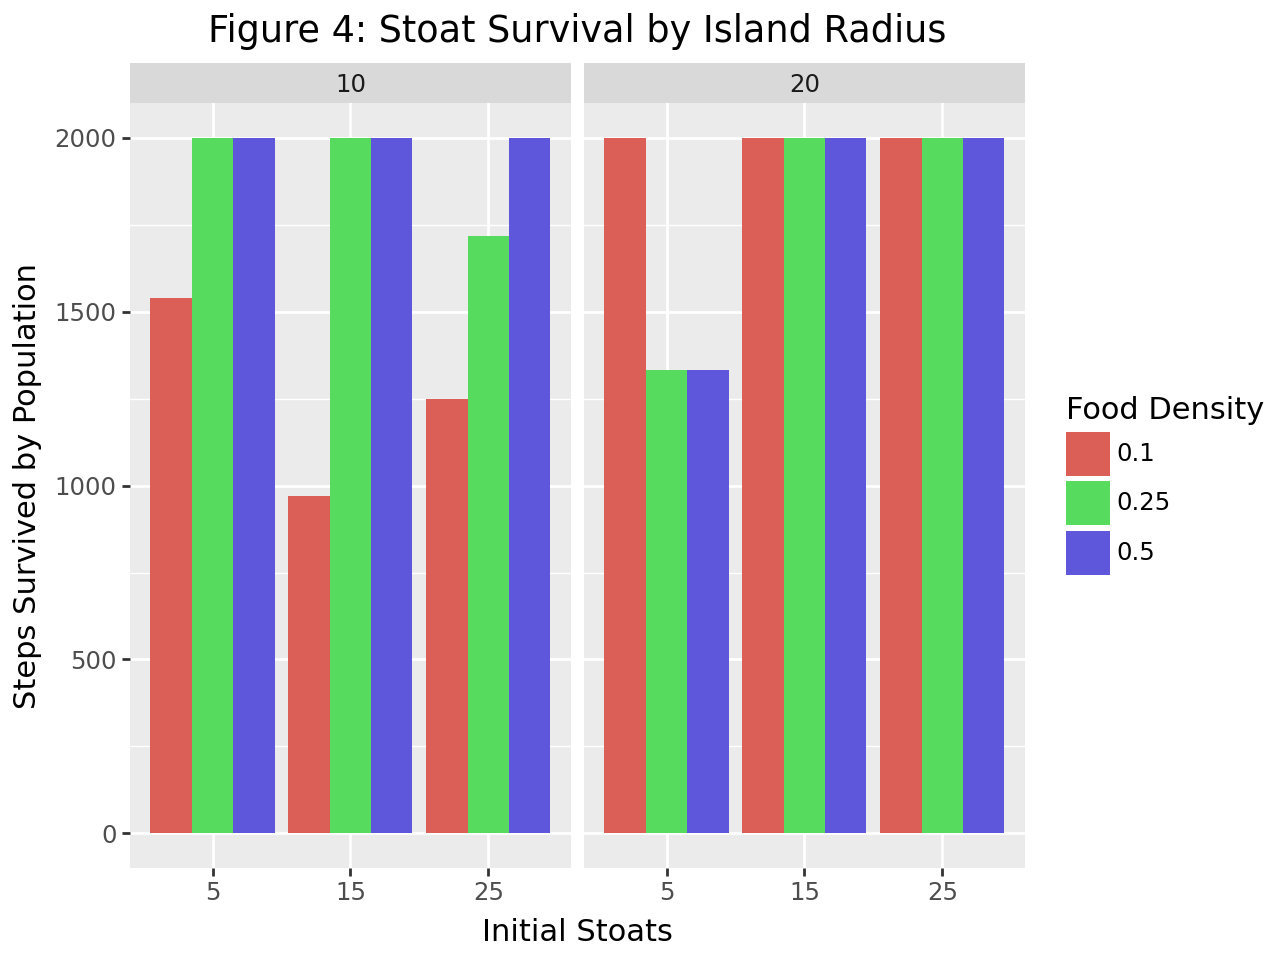

In [16]:
(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("radius")
    + ggtitle("Figure 4: Stoat Survival by Island Radius")
    + xlab("Initial Stoats")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

As you can see above, food density seems to be the primary factor which determined the survivorship of the stoats. On the small island, none of the stoat groups were able to survive with a density of 0.1. Two out of three groups on the small island survived through the simulation with a density of 0.25, and all three groups survived with a plentiful food density of 0.5 on the small island. On the larger island, survivability seems to be improved overall, likely because of the increased amount of total food. The number of initial stoats does not seem to have an impact on the survivability, likely due to how quickly they reproduce. 

**AIM 2:**

Our second aim was to evaluate the efficacy of stoat trapping. To investigate, we first looked at the population dynamics within our ABM, with an equal number of traps as initial stoats. Each trap could catch up to 3 stoats, to imitate the resetting of the trap by humans over time.

In [17]:
df = pd.read_csv("/kaggle/input/stoats-traps-population-equal-traps/stoatdeath_singleexample_density025_15stoats_r10_15traps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1

In [18]:
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]

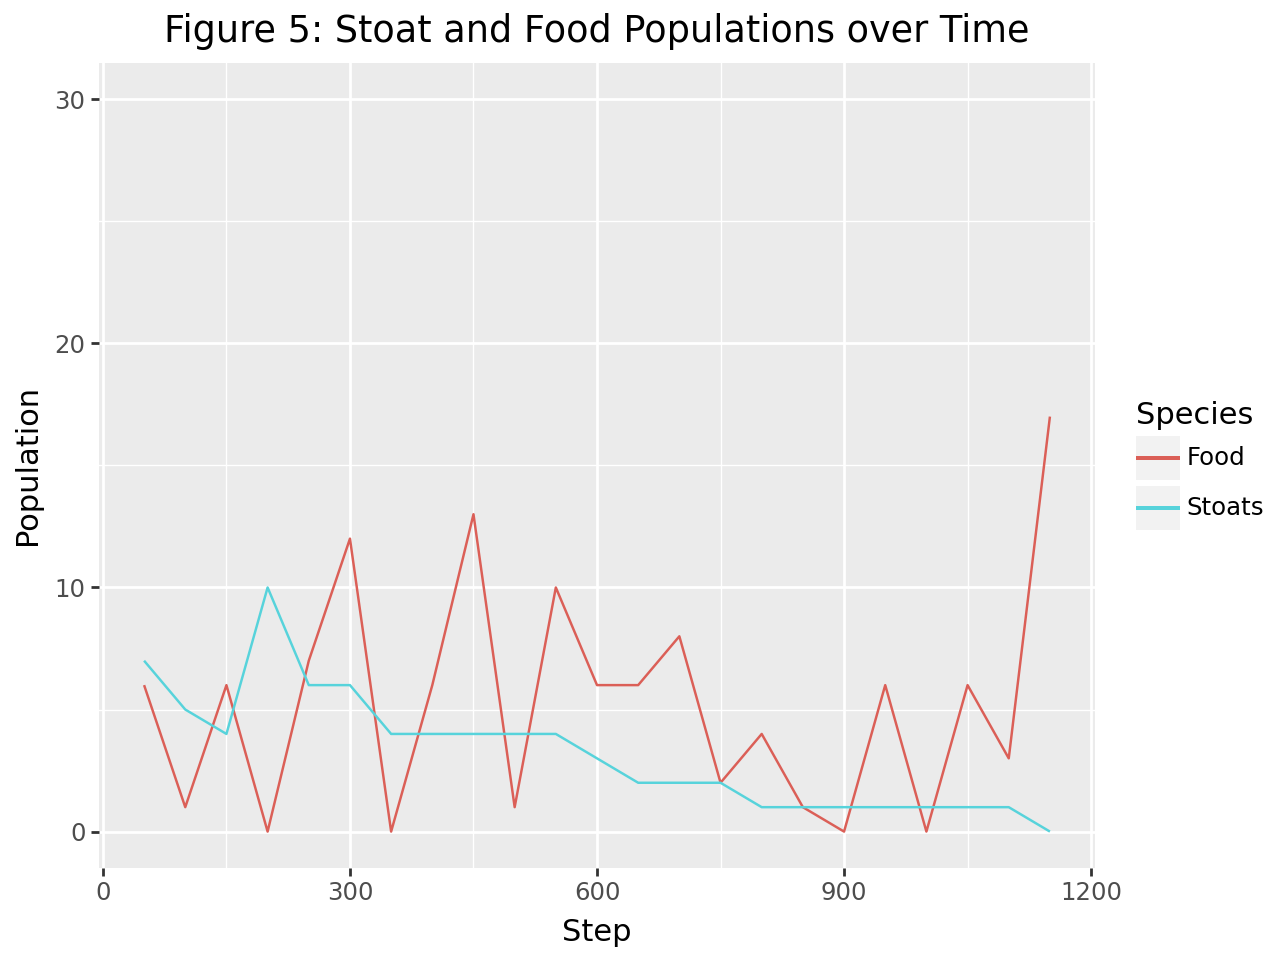

In [19]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ylim(0, 30)
    + ggtitle("Figure 5: Stoat and Food Populations over Time")
    + labs(color="Species")
    + xlab("Step")
    + ylab("Population")
)

As you can see, stoat populations do not show the same cyclic patterns as before, and the food populations do not crash quite as significantly as before. 

To further evaluate this, we reran the same batch experiments, introducing either the same number of traps as stoats or double the number of traps as stoats. 

In [20]:
df = pd.read_csv("/kaggle/input/stoats-radius-10/all.csv")
df["trap status"] = df["traps"] / df["stoats"]

In [21]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

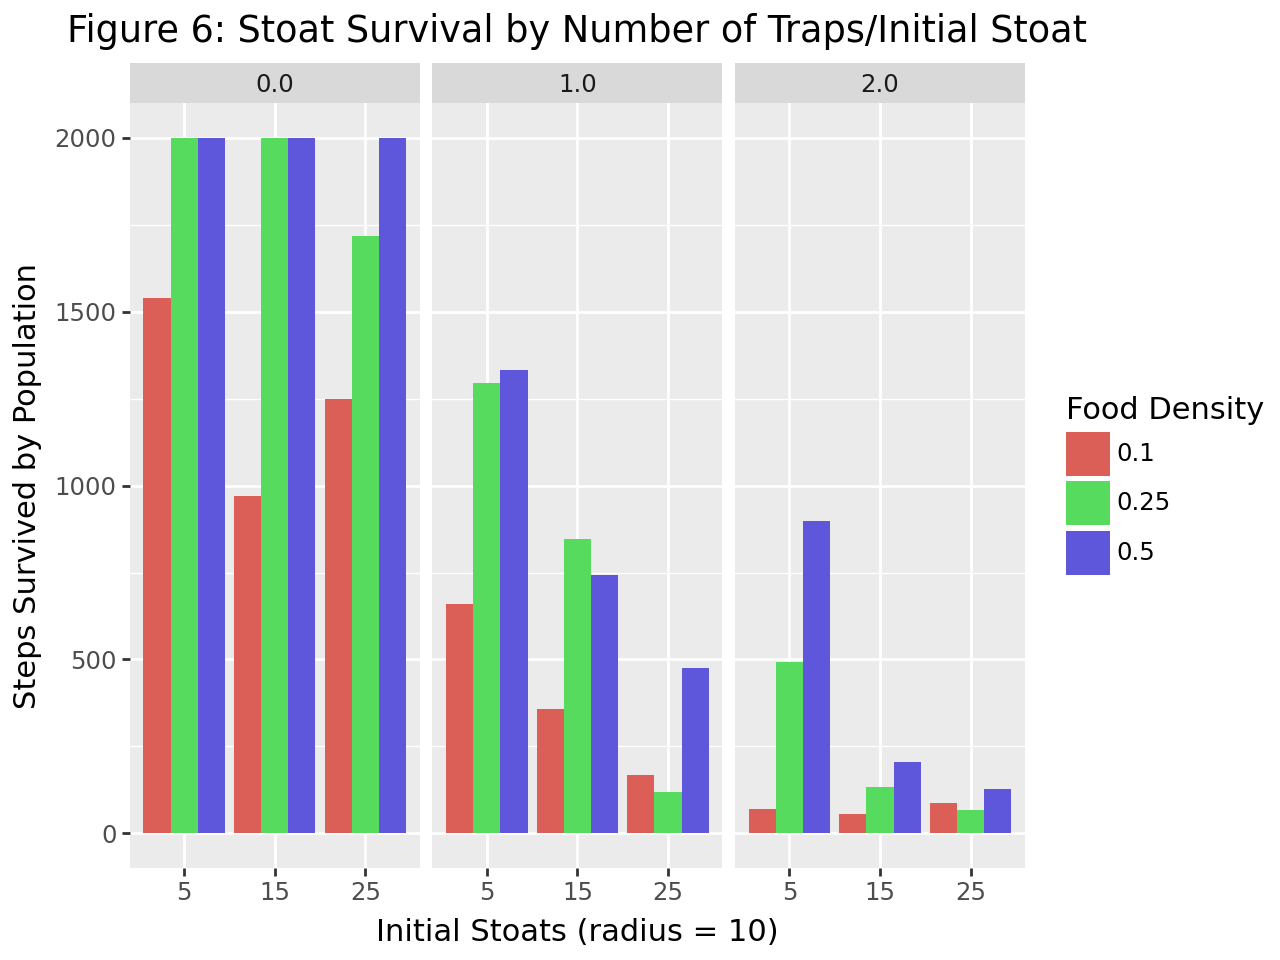

In [22]:

(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("trap status")
    + ggtitle("Figure 6: Stoat Survival by Number of Traps/Initial Stoat")
    + xlab("Initial Stoats (radius = 10)")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

In [23]:
df = pd.read_csv("/kaggle/input/stoats-radius-20/all.csv")
df["trap status"] = df["traps"] / df["stoats"]

In [24]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

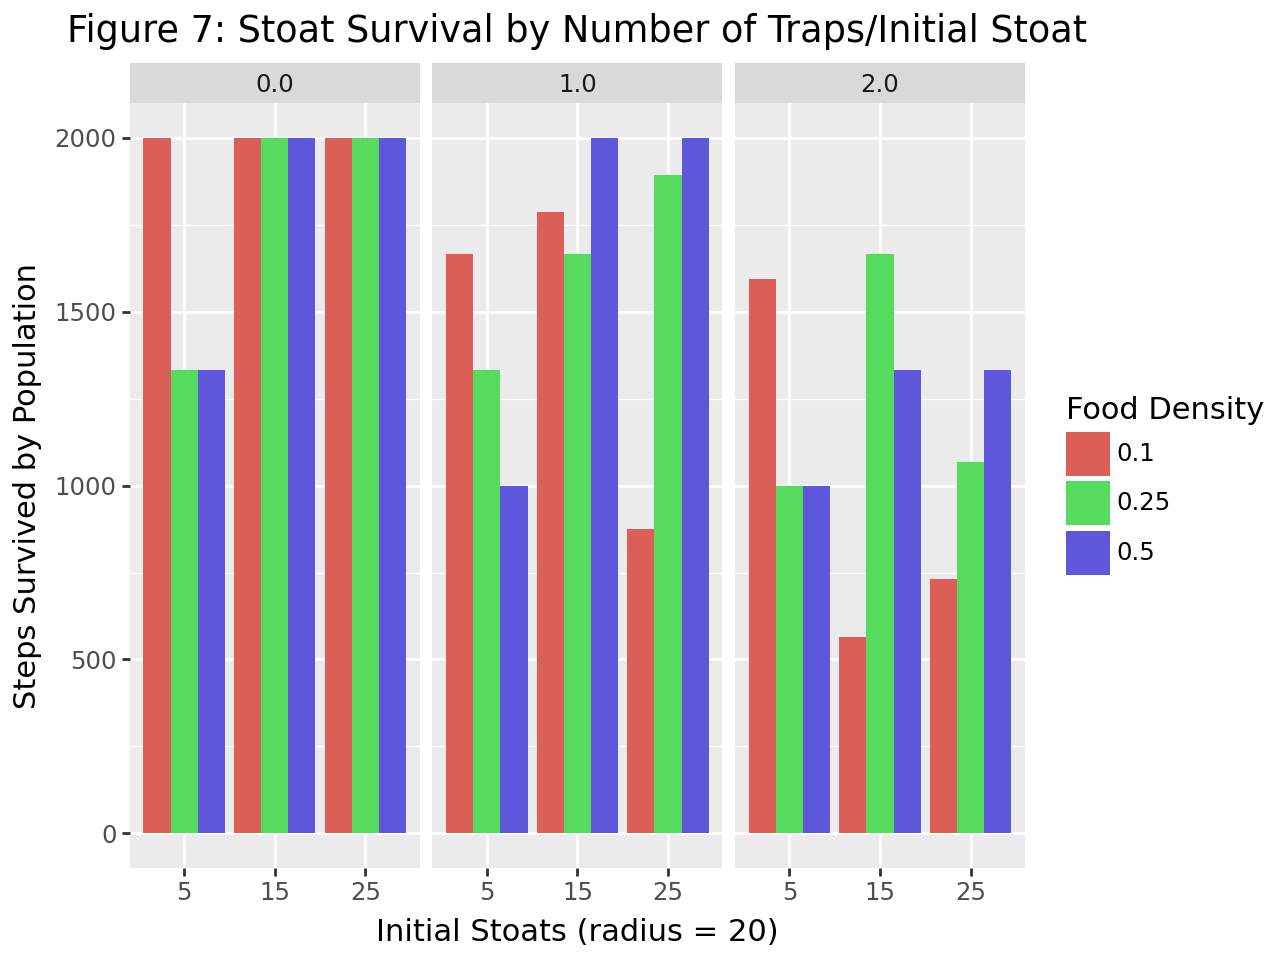

In [25]:
(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("trap status")
    + ggtitle("Figure 7: Stoat Survival by Number of Traps/Initial Stoat")
    + xlab("Initial Stoats (radius = 20)")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

As seen above, implementing an equal number of traps as stoats is *effective* at reducing stoat populations in an isolated area, particularly on smaller islands, where the stoats are more likely to be caught. Further, implenting double the number of traps as initial stoats is *extremely effective*, especially on smaller islands. On larger islands, the effect is less pronounced, but we can still observe a distinct decrease in the number of steps survived by the population. In particular, none of the stoat populations were able to survive to the end of the simulation when traps were present, regardless of food density or initial food density. 

**AIM 3:**

Our final aim was to evaluate the effects of stoat invasion on prey populations. First, we can take a look at the population dynamics of the stoats and the prey on an island of radius 10, 15 initial stoats, a food density of 0.25, and no traps. 

In [26]:
df = pd.read_csv("/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_notraps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]

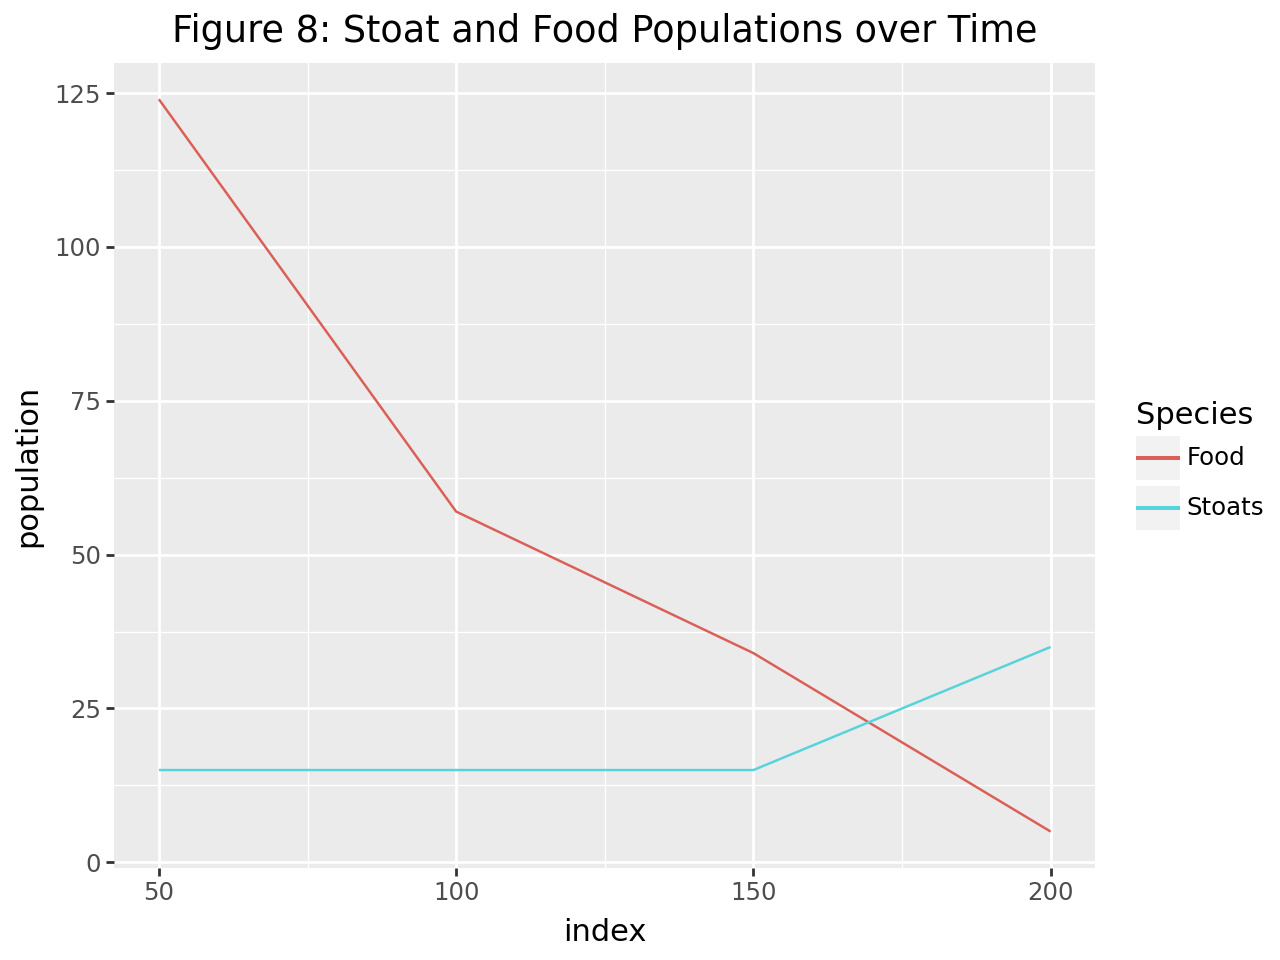

In [27]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ggtitle("Figure 8: Stoat and Food Populations over Time")
    + labs(color="Species")
)

We see that even before a slight increase in stoat population, the food population is devastated. 

To further evaluate this, we repeated a subset of our previous experimental conditions, but the model terminated when food density dropped under a threshold, instead of when the final stoat died. We evaluated the impacts on prey with an inital density of 0.1, 0.25, and 0.5 with 15 stoats on an island of radius 10. We simulated the impacts with zero traps and with an equal number of traps as stoats. 

In [28]:
df = pd.read_csv("/kaggle/input/stoats-steps-to-food-death/stepstofooddeath.csv")
df["trap status"] = df["traps"] / df["stoats"]

In [29]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

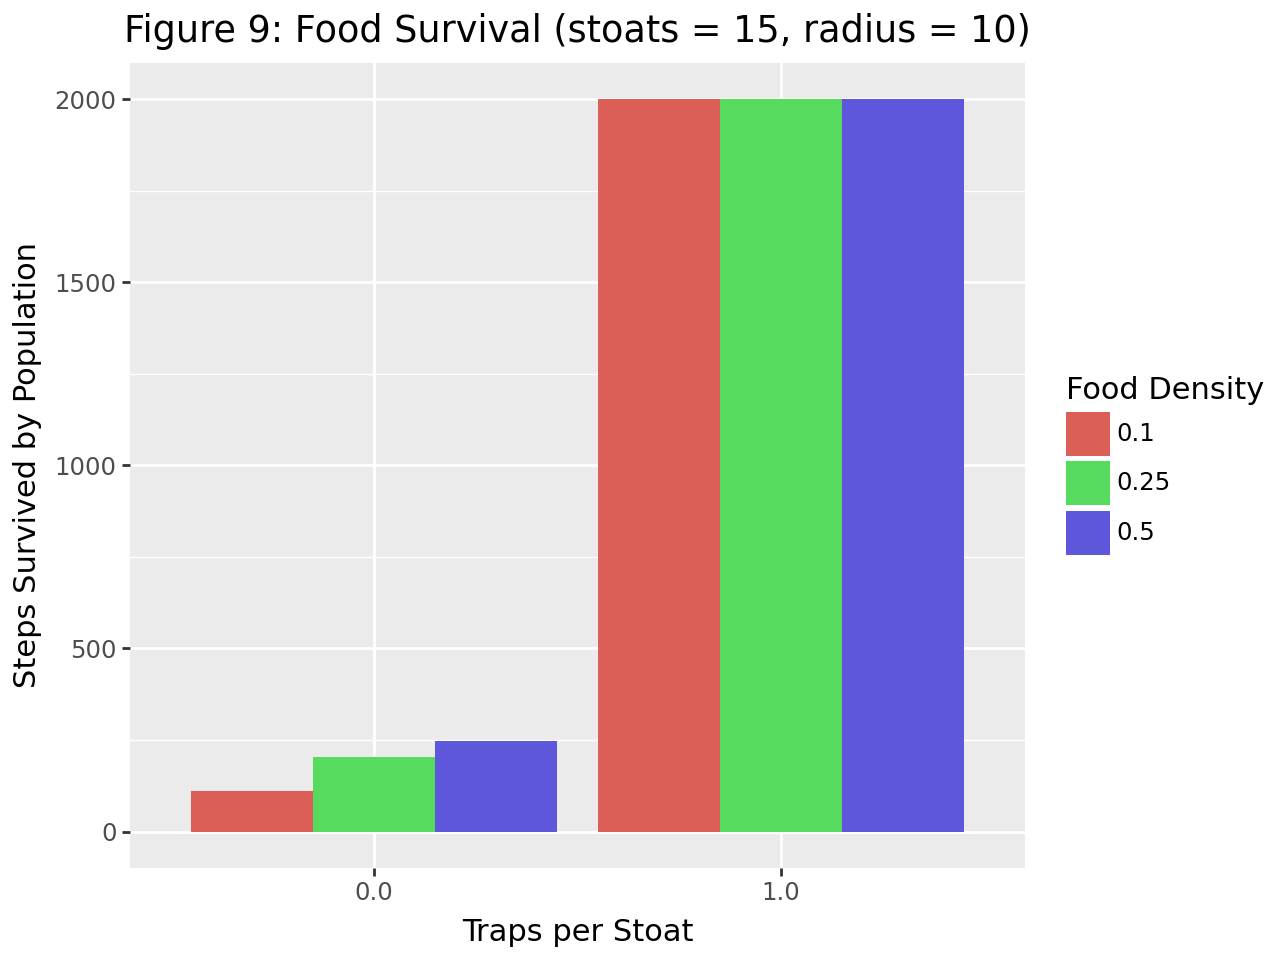

In [30]:
(
    ggplot(df_average, aes(x="trap status", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + ggtitle("Figure 9: Food Survival (stoats = 15, radius = 10)")
    + xlab("Traps per Stoat")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

Food survival appears to be significantly improved by the introduction of traps! The food population is devastated very quickly by stoat populations in the absence of traps. The introduction of one trap per stoat allows the food to survive for the duration of the simulation!

# 5. Conclusions

Our findings suggest that stoat populations have a significant impact on prey populations in New Zealand islands. For example, in our models, prey populations quickly dip to 0 followed by subsequent growth of stoat populations (Figs. 1, 2, 3, & 8). Figures 1 and 3 model an environment where prey populations can regenerate/rebound periodically to support stoat growth. The resulting figures display a predator-prey relationship where an increase in prey leads to an increase in stoats, which causes the prey population to decline, leading to a subsequent decrease in stoats. Alternatively, Figures 2 and 8 display how prey populations are unable to recover when their populations reach 0. These decreases in prey populations can mean significant losses in biodiversity in New Zealand. As there are many endemic birds on the island, the presence of stoats could mean the possible extinction for many species.

Initial evaluations of population dynamics in the presence of traps revealed that trapping is effective at reducing stoat populations when present at a 1:1 ratio of traps to stoats (Figure 5). More detailed investigations into the ideal ratio of traps to stoats indicate that a 2:1 ratio of traps to stoats is even more effective at reducing stoat populations, regardless of food density, island size, or the initial number of stoats (Figures 6 & 7). Delayed trapping may make it difficult to implement ideal trap-to-stoat ratios, particularly if the stoat population grows rapidly. Similarly, despite being more effective, higher trap ratios such as 2:1 may be impractical in cases of larger stoat populations, but a 1:1 ratio remains effective. Overall, early and proactive trapping seems to be the best strategy for effective stoat population management. 

# 6. Future Directions

**Dynamical Systems**

Modeling the population dynamics of stoats and their prey provides key insights for conservation management. A major limitation of this model is the generalization of prey species into a single, indistinguishable population. In the future, it may be helpful to narrow the focus onto specific prey, particularly endemic bird populations. Further modeling should also begin to consider traps and their effects on both stoat and prey populations. 

**Agent Based Modeling**

There are several limitations to this model that provide opportunities for future work. A great simplification made by this model was that every trap could catch stoats with 100% efficacy, which is almost certainly untrue. It may be necessary to factor in stoat behaviors around traps in the real world. Given the success of the traps in the simulation, it may also be pertinent to further investigate the optimal number of traps per stoat on variable island sizes. It may also be possible to investigate the effects of different kinds of traps. The most interesting thing to consider with the traps is their proximity to the stoat habitats. Further simulations could evaluate the optimal trapping locations, based on stoat behaviors and where they prefer to build their homes. 

Additional investigations should be conducted with specific prey species, particularly ground-dwelling birds. This model generalized all prey species into a single, randomly-moving food population, which provides very little insight into specific populations. Modeling the specific behaviors of the birds in relationship to the stoats could provide even further insight for conservation management. 

# 7. References

[1] Barlow, N. & Choquenot, D. (2002). Predicting the impact and control of stoats: a review of modelling approaches. Science for Conservation, 191. SFC191.pdf

[2] Gulamhusein, A.P. & Tam, W.H. (1974). Reproduction in the male stoat, Mustela erminea. Journal of Reproduction and Fertility, 41(1), 303-312. https://rep.bioscientifica.com/downloadpdf/journals/rep/41/2/jrf_41_2_006.pdf

[3] Nature Publishing Group. (2014). Nature news. https://www.nature.com/scitable/knowledge/library/population-ecology-at-work-managing-game-populations-50937864/#:~:text=a%20given%20time.-,Logistic%20growth%20model.,rate%20of%20change%20(r. Accessed November 2024.

[4] Travis, J. M., Harris, C. M., Park, K. J., & Bullock, J. M. (2011). Improving prediction and management of range expansions by combining analytical and individual‐based modelling approaches. Methods in Ecology and Evolution, 2(5), 477–488. https://doi.org/10.1111/j.2041-210x.2011.00104.x

[5] Veale, A. J., Hannaford, O. D., Russell J. C., & Clout M. N. (2012) Modelling the distribution of stoats on New Zealand offshore islands. New Zealand Journal of Ecology, 36(1), 38-47. https://newzealandecology.org/nzje/3019 